In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Aluminium Historical Data

In [2]:
# Loading the relevant columns of the dataset.

df = pd.read_csv('Aluminium Historical Data_2012.csv', index_col = ['Date'], parse_dates=['Date'])
df = df['Price']
df = df.str.replace(',','').astype(float)
df = df.iloc[::-1]
df.dtypes

dtype('float64')

In [3]:
df

Date
2014-06-16    1840.25
2014-06-17    1852.00
2014-06-18    1874.50
2014-06-19    1890.50
2014-06-20    1888.50
               ...   
2022-06-16    2504.50
2022-06-17    2498.00
2022-06-20    2527.00
2022-06-21    2533.50
2022-06-22    2528.00
Name: Price, Length: 2028, dtype: float64

In [4]:
df.describe()

count    2028.000000
mean     1989.368787
std       416.875708
min      1435.750000
25%      1726.187500
50%      1888.250000
75%      2104.500000
max      3849.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'Aluminium Historical Data')

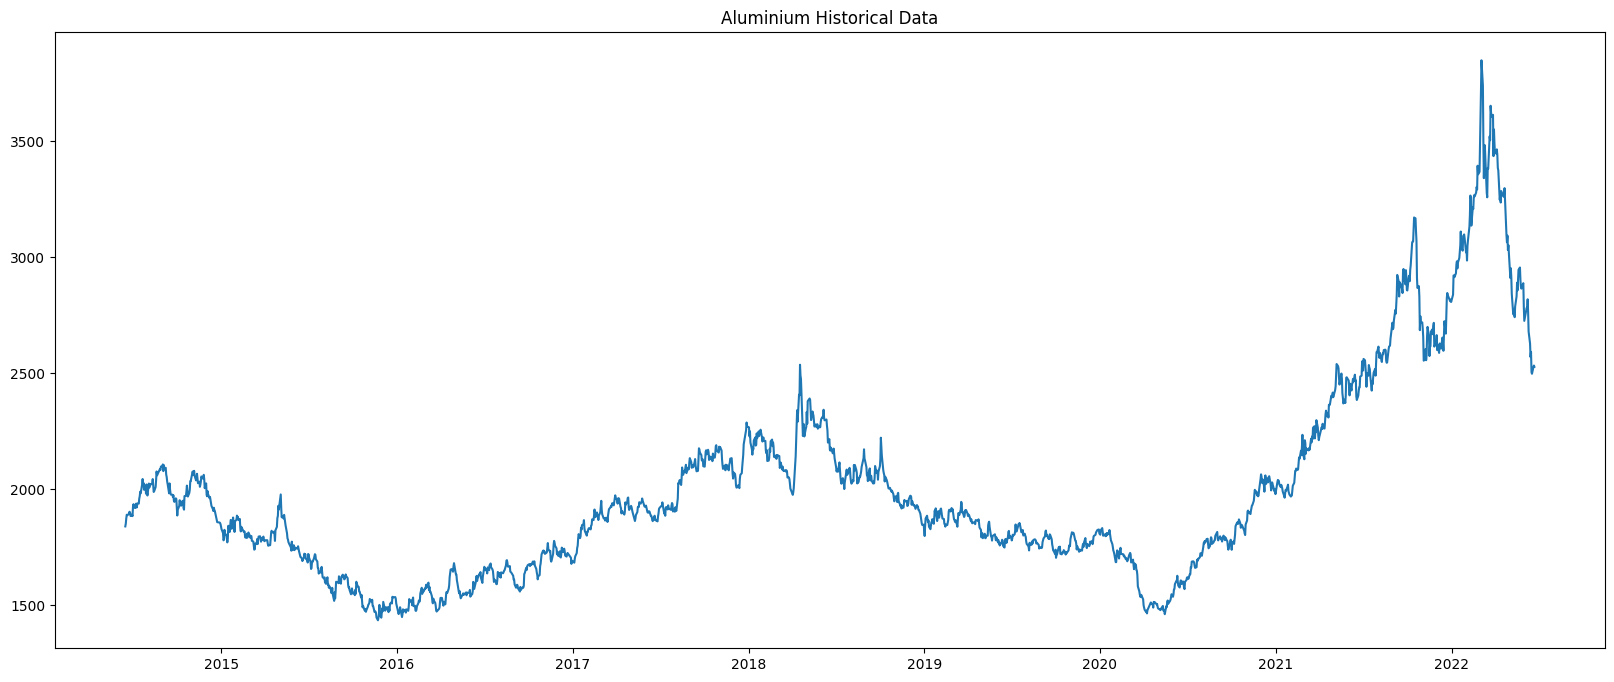

In [5]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(df)
plt.title(f'Aluminium Historical Data')

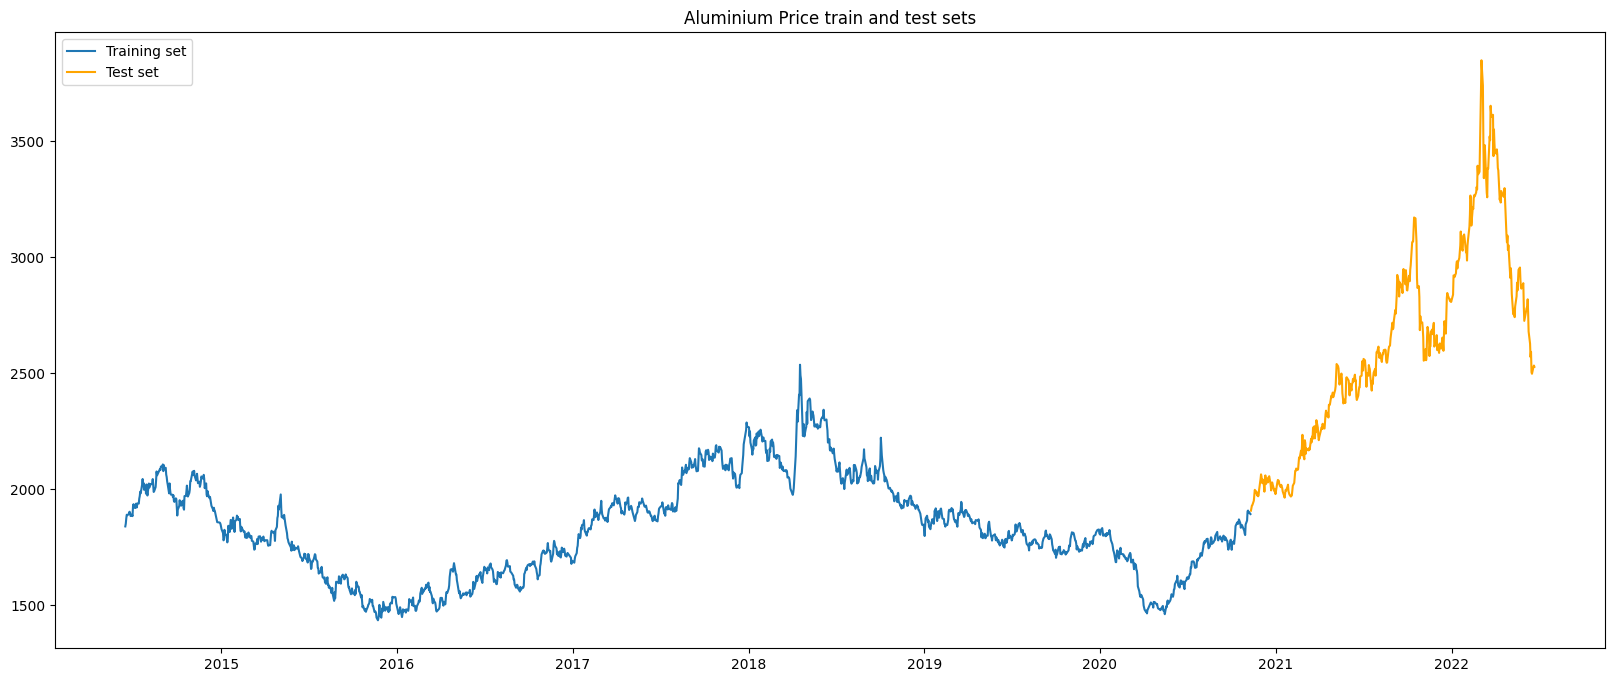

In [6]:
# Lets see how it would be split using 20% of data to test
 
test_size = int(round(df.shape[0]*0.2))

df_train = df[:-test_size]
df_test = df[-test_size:]

plt.title('Aluminium Price train and test sets')
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend()

In [7]:
# Splitting data in Train x Test

X_train = df_train.index.to_numpy()
y_train = df_train.to_numpy()
X_test = df_test.index.to_numpy()
y_test = df_test.to_numpy()
len(X_train), len(X_test), len(y_train), len(y_test)

(1622, 406, 1622, 406)

In [8]:
# Windowing Dataset.

HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

full_windows, full_labels = make_windows(x = df.values, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2021, 2021)

In [9]:
# View 3 windows and its label:

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [1840.25 1852.   1874.5  1890.5  1888.5  1892.5  1901.  ] -> Label: [1903.5]
Window: [1852.  1874.5 1890.5 1888.5 1892.5 1901.  1903.5] -> Label: [1898.]
Window: [1874.5 1890.5 1888.5 1892.5 1901.  1903.5 1898. ] -> Label: [1885.]


In [10]:
# Splitting the windowed dataset.

def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  return train_windows, test_windows, train_labels, test_labels
  
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1616, 405, 1616, 405)

In [11]:
# Checking if the split was correct

for i in range(5):
  print(f"Window: {train_windows[i]} -> Label: {train_labels[i]}")

Window: [1840.25 1852.   1874.5  1890.5  1888.5  1892.5  1901.  ] -> Label: [1903.5]
Window: [1852.  1874.5 1890.5 1888.5 1892.5 1901.  1903.5] -> Label: [1898.]
Window: [1874.5 1890.5 1888.5 1892.5 1901.  1903.5 1898. ] -> Label: [1885.]
Window: [1890.5 1888.5 1892.5 1901.  1903.5 1898.  1885. ] -> Label: [1890.75]
Window: [1888.5  1892.5  1901.   1903.5  1898.   1885.   1890.75] -> Label: [1884.5]


In [12]:
# Reshape windows from [samples, timesteps] into [samples, timesteps, features]
train_windows = train_windows.reshape((train_windows.shape[0], train_windows.shape[1], 1))
test_windows = test_windows.reshape((test_windows.shape[0], test_windows.shape[1], 1))
train_windows.shape, test_windows.shape

((1616, 7, 1), (405, 7, 1))

### LSTM Model

In [13]:
# Building functions to evaluate models.

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.initializers import HeNormal

def make_preds(model, input_data):
  forecast = model.predict(input_data)
  
  return tf.squeeze(forecast)

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # 1 coz shifting of 1 day

  return mae / mae_naive_no_season

def evaluate_pred(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()}

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Al Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [14]:
# Built, train and evaluate Vanilla LSTM model

vanilla_model = Sequential()
vanilla_model.add(LSTM(100, activation='relu', kernel_initializer = HeNormal(42), input_shape=(WINDOW_SIZE, 1)))
vanilla_model.add(Dense(1))
vanilla_model.compile(optimizer='adam', loss='mse')
vanilla_model.fit(train_windows, train_labels, epochs=300, verbose=0)
vanilla_model_preds = make_preds(vanilla_model, test_windows)
vanilla_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=vanilla_model_preds)
vanilla_model_results

13/13 [==============================] - 0s 2ms/step


{'mae': 35.861927,
 'mse': 2679.745,
 'rmse': 51.766254,
 'mape': 1.3171347,
 'mase': 1.0479723}

In [15]:
# Built, train and evaluate Stacked LSTM model

stacked_model = Sequential()
stacked_model.add(LSTM(100, activation='relu', kernel_initializer = HeNormal(42), return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
stacked_model.add(LSTM(100, activation='relu', kernel_initializer = HeNormal(7)))
stacked_model.add(Dense(1))
stacked_model.compile(optimizer='adam', loss='mse')
stacked_model.fit(train_windows, train_labels, epochs=3s00, verbose=0)
stacked_model_preds = make_preds(stacked_model, test_windows)
stacked_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=stacked_model_preds)
stacked_model_results

13/13 [==============================] - 0s 3ms/step


{'mae': 36.62957,
 'mse': 2859.0364,
 'rmse': 53.469955,
 'mape': 1.342744,
 'mase': 1.0704048}

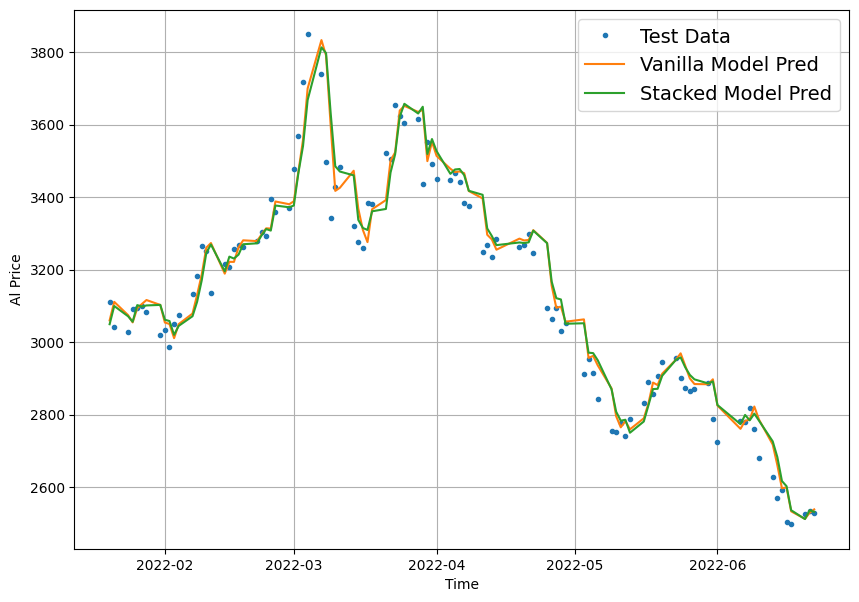

In [16]:
offset = 300
plt.figure(figsize=(10, 7))
 
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=vanilla_model_preds, start=offset, format="-", label="Vanilla Model Pred")
plot_time_series(timesteps=X_test[-len(test_windows):], values=stacked_model_preds, start=offset, format="-", label="Stacked Model Pred")

In [17]:
# Built, train and evaluate Vanilla LSTM model with 250 units

vanilla250_model = Sequential()
vanilla250_model.add(LSTM(250, activation='relu', kernel_initializer = HeNormal(42), input_shape=(WINDOW_SIZE, 1)))
vanilla250_model.add(Dense(1))
vanilla250_model.compile(optimizer='adam', loss='mse')
vanilla250_model.fit(train_windows, train_labels, epochs=300, verbose=0)
vanilla250_model_preds = make_preds(vanilla250_model, test_windows)
vanilla250_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=vanilla250_model_preds)
vanilla250_model_results

13/13 [==============================] - 0s 2ms/step


{'mae': 38.452858,
 'mse': 2877.2478,
 'rmse': 53.639984,
 'mape': 1.4082061,
 'mase': 1.1236856}

In [18]:
# Built, train and evaluate Stacked LSTM model with 250 units each

stacked250_model = Sequential()
stacked250_model.add(LSTM(250, activation='relu', kernel_initializer = HeNormal(42), return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
stacked250_model.add(LSTM(250, activation='relu', kernel_initializer = HeNormal(7)))
stacked250_model.add(Dense(1))
stacked250_model.compile(optimizer='adam', loss='mse')
stacked250_model.fit(train_windows, train_labels, epochs=300, verbose=0)
stacked250_model_preds = make_preds(stacked250_model, test_windows)
stacked250_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=stacked250_model_preds)
stacked250_model_results

13/13 [==============================] - 0s 4ms/step


{'mae': 84.511894,
 'mse': 9233.052,
 'rmse': 96.08877,
 'mape': 3.1932864,
 'mase': 2.4696422}

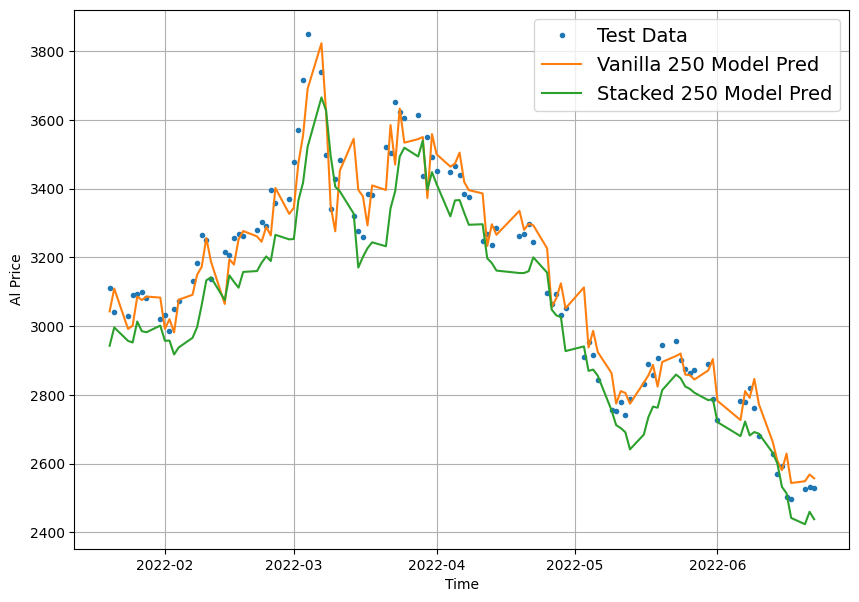

In [19]:
offset = 300
plt.figure(figsize=(10, 7))
 
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=vanilla250_model_preds, start=offset, format="-", label="Vanilla 250 Model Pred")
plot_time_series(timesteps=X_test[-len(test_windows):], values=stacked250_model_preds, start=offset, format="-", label="Stacked 250 Model Pred")